In [1]:
import pandas as pd
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
from torch.nn.parallel.scatter_gather import scatter_kwargs

# Read the CSV file
# Set random seed for reproducibility
np.random.seed(42)

# Generate x values from 0 to 20
X = np.linspace(0, 20, 100)

# Create linear relationship (y = 2x + 1) with noise
slope = 2
intercept = 1
noise = np.random.normal(0, 1, 100)  # Gaussian noise with mean 0 and std 1
y = slope * X + intercept + noise

X_mean = X.mean()
X_centered = X - X_mean


# Create the linear regression model
with pm.Model() as model_g:
    # Priors for unknown model parameters
    alpha_tmp = pm.Normal('alpha_tmp', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=1)
    epsilon = pm.HalfCauchy('epsilon', 5)
    
    
    # Expected value of outcome
    mu = pm.Deterministic('mu', alpha_tmp + beta * X_centered.reshape(-1))
    
    alpha = pm.Deterministic('alpha', alpha_tmp - beta * X_mean)
    
    # Likelihood (sampling distribution) of observations
    y_pred = pm.Normal('y_pred', mu=mu, sigma=epsilon, observed=y)
    
    # Inference
    idata_g = pm.sample(2000, tune=2000, return_inferencedata=True)
    

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_tmp, beta, epsilon]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 37 seconds.


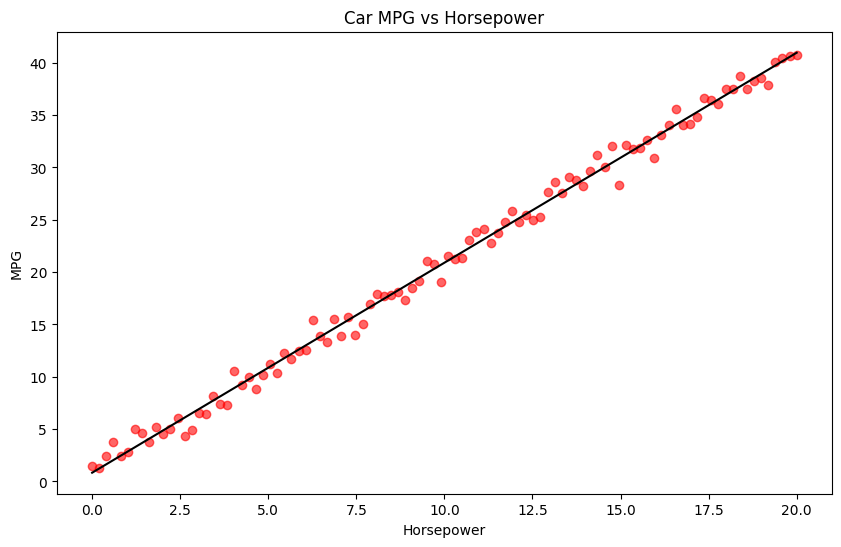

In [2]:
# plot the line and the data
# Add to the graph the 95% HDI for the line
plt.figure(figsize=(10, 6))
plt.scatter(X, y, c='r', alpha=0.6)
plt.xlabel('Horsepower')
plt.ylabel('MPG')
plt.title('Car MPG vs Horsepower')
plt.plot(X, idata_g.posterior['alpha'].mean().item() + idata_g.posterior['beta'].mean().item() * X, c='k')

# Add to the graph 